# Чтение данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd

train = pd.read_csv("data/train.tsv.zip")
test = pd.read_csv("data/test.tsv")
sample_submission = pd.read_csv("data/sample_submission.tsv")

C:\Users\shcherbakov2-ia\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
train['is_train']=1
test['is_train']=0
full_data = pd.concat([train.reset_index(),test.reset_index()], axis=0, sort=False).drop(['index'], axis=1)
full_data.rename({'y':'y_orig'}, axis=1, inplace=True)
full_data.shape

(74473, 67)

In [4]:
full_data['y'] = np.log(full_data['y_orig'])

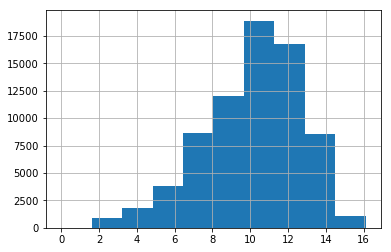

In [5]:
full_data['y'].hist()
plt.show()

# Генерация фичей

# Разбиение на подвыборки

In [6]:
dev = full_data.loc[(full_data['Num']<=250000) & (full_data['is_train']==1)]
valid = full_data.loc[(full_data['Num']>250000) & (full_data['is_train']==1)]

In [7]:
dev_y = dev[['y', 'y_orig']]
dev_X = dev.drop(['y', 'is_train', 'y_orig' ],axis=1)

valid_y = valid[['y', 'y_orig']]
valid_X = valid.drop(['y', 'is_train', 'y_orig'],axis=1)

In [9]:
full_train_X = full_data.loc[(full_data['is_train']==1)].drop(['y', 'is_train', 'y_orig'], axis=1)
full_train_y = full_data.loc[(full_data['is_train']==1)][['y', 'y_orig']]

In [10]:
test_X = full_data.loc[full_data['is_train']==0].drop(['y', 'is_train', 'y_orig'], axis=1)

# Построение модели

In [11]:
import lightgbm as lgbm
import numpy as np
from sklearn.metrics import mean_absolute_error

In [12]:
def smape(f,a):
    top = np.fabs(f-a)
    bot = (np.fabs(f) + np.fabs(a))/2
    return 100/len(a) * np.sum(top/bot)

def smape_scorer(estimator, X,y):
    y_predicted = estimator.predict(X)
    return smape(y_predicted, y)

In [24]:
n_estimators_row = [27, 29, 30]
results=list()

for n_estimators_ in n_estimators_row:
    reg = lgbm.LGBMRegressor(n_estimators=n_estimators_)
    reg.fit(dev_X, dev_y['y'])
    
    dev_predicted = np.exp(reg.predict(dev_X))
    dev_smape = smape(dev_predicted, dev_y['y_orig'])
    
    valid_predicted = np.exp(reg.predict(valid_X))
    valid_smape = smape(valid_predicted, valid_y['y_orig'])
    
    results.append([[n_estimators_], dev_smape, valid_smape])
    
results

[[[27], 27.632528970857898, 30.054037117864937],
 [[29], 26.458484607116183, 29.128802556516018],
 [[30], 25.942772522287367, 28.780309920556398]]

In [27]:
dev_predicted

array([ 93490.9187652 ,  52824.95241408,  82951.4848213 , ...,
       144110.315623  ,  17127.11557197,   1765.27928138])

In [30]:
reg = lgbm.LGBMRegressor(n_estimators=30)
reg.fit(full_train_X, full_train_y['y'])
full_train_predicted=reg.predict(full_train_X)

# Test

In [31]:
test_predicted=reg.predict(test_X)

In [33]:
np.exp(test_predicted)

array([  1815.05047868,  29474.00080721, 314443.32714647, ...,
        19924.08851303,    361.19987703,   6055.05009671])

In [37]:
full_test = test_X.copy()
full_test['y'] = np.exp(test_predicted)

In [44]:
mean_prediction = full_test[['year', 'week', 'y', 'item_id']].groupby(['year', 'week', 'item_id'], as_index=False).agg({'y':'mean'})

In [45]:
test_boosting= pd.merge(left=test[['Num', 'year', 'week', 'item_id']], right=mean_prediction, how='left')

In [59]:
test_boosting['y_boosted'] = full_test['y']

In [58]:
full_test.loc[(full_test['item_id']==20447918) & (full_test['year']==2015) & (full_test['week']==3), 'y']

0      1815.050479
226    1303.570149
678    1822.248028
Name: y, dtype: float64

In [60]:
test_boosting[(test_boosting['item_id']==20447918) & (test_boosting['year']==2015) & (test_boosting['week']==3)]

,Num,year,week,item_id,y,y_boosted
0,348622,2015,3,20447918,1646.956219,1815.050479
226,349519,2015,3,20447918,1646.956219,1303.570149
678,350191,2015,3,20447918,1646.956219,1822.248028


In [61]:
test_boosting.to_csv('predictions/boosting_full_output.csv', index=False)

In [62]:
sample_submission['y']=np.exp(test_predicted)
sample_submission.head()

,Num,y
0,348622,1815.050479
1,348623,29474.000807
2,348624,314443.327146
3,348625,29881.355623
4,348626,59.320674


In [63]:
sample_submission.to_csv('predictions/goosting.csv', index=False)